# Introduction to data analysis for natural and social sciences
This notebook contitutes the first part of the exam. Here the steps of article "Patient-specific Boolean models of signalling networks guide personalised treatments" are retraced and some results regarding Boolean models reproduced.

## Imports and global settings

In [6]:
import biolqm
import ginsim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

This notebook has been executed using the docker image `colomoto/colomoto-docker:2023-06-01`

In [7]:
PATH_FILES = "report"

EXT_EXCEL = "xlsx"
EXT_TAB = "tsv"

# Prostate Boolean model construction
The Boolean model is constructed starting from information available in literature. Then further pathways are identified by the use of software ROMA and pypath and they are added to the existing network.

## Boolean model construction
The authors collected all data regarding the network, such as nodes, their role, logical rules, in the two following Excel files:

In [8]:
fname_nodes_pathways = "Montagud2022_nodes in pathways.xlsx"
fname_nodes_network = "Montagud2022_interactions_sources.xlsx"

Data are loaded in Pandas dataframe to ease their manipulation.

In [9]:
df_nodes_pathways = pd.read_excel(
    io=f"{PATH_FILES}/{fname_nodes_pathways}",
    header=None,
    names=["node", "pathway"]
)
sheet_interactions = "Nodes"
df_nodes_interactions = pd.read_excel(
    io=f"{PATH_FILES}/{fname_nodes_network}",
    sheet_name=sheet_interactions,
    header=1,
    converters={"Reference: PMID": lambda c: np.str_(c).strip()}  # Remove a useless line break in a cell.
)
sheet_unique="Nodes_unique"
df_nodes_unique = pd.read_excel(
    io=f"{PATH_FILES}/{fname_nodes_network}",
    sheet_name=sheet_unique
)

In [10]:
# One single logical rule is associated to each node, indeed the result of grouping by node and rule is a list of exactly 133 rows.
df_count = df_nodes_interactions.groupby(["Target node", "Logical rule"]).count()
display(df_count)
del df_count

,,HUGO names,Interaction type,Source,Description,Reference: PMID
Target node,Logical rule,,,,,
AKT,((HSPs | (PDK1 & PIP3) | PIP3 | (SHH & PIP3)) & !PTCH1),5,5,5,5,5
AMPK,(ATR | HIF1 | AMP_ATP | ATM) & !FGFR3,6,6,6,6,6
AMP_ATP,(!Nutrients),1,1,1,1,1
APAF1,((Caspase8 | BAX | p53 | Bak | HSPs) & !Bcl_XL & !BCL2 & !AKT),8,8,8,8,8
AR,((GLI | EP300 | HSPs | NKX3_1 | EZH2 | NCOA3 | PKC | SMAD | Androgen) & !PTEN & !NCOR1 & !NCOR2 & !MDM2),13,13,13,13,13
...,...,...,...,...,...,...
p21,((p53 | SMAD | HIF1 | ZBTB17) & !TERT & !MYC_MAX & !MDM2 & !AKT & !ERK),9,9,9,9,9
p38,(MAP3K1_3 & !ERK & !GADD45),3,3,3,3,3
p53,((Acidosis | CHK1_2 | p38 | HIF1) & !BCL2 & !MDM2 & !HSPs & !Snail),9,9,9,9,9


In [11]:
# df_nodes_unique contains only 121 nodes and not 133 as df_nodes_pathways.
# In other words, df_nodes_unique["Node"] should be a subset of df_nodes_pathways["node"]. Why?
df = df_nodes_pathways.set_index("node")
df_subset = df_nodes_unique.set_index("Node")

# The input nodes should be all removed, since they are not regulated by authors' choice,
# hence they are not part of any pathway. But this is not what happens.
display(df.loc[df["pathway"] == "Input"])
display(df.drop(labels=df_subset.index, errors="ignore"))

# Moreover, in df_nodes_unique there is a node called MAX which is not part of the nodes considered for the final network.
# Surprisingly, it is not present among the nodes in df_nodes_interactions.
try:
    df.drop(labels=df_subset.index)
except Exception as e:
    print(e)
finally:
    del df
    del df_subset

# In conclusion, it seems that the choice of nodes from the Excel files can not be deduced directly
# just from the observation of the content of the files.
# In particular, I should use data in df_nodes_unique with caution,
# since their relation with the other data is not straightforward.

,pathway
node,
Acidosis,Input
Androgen,Input
Carcinogen,Input
EGF,Input
FGF,Input
fused_event,Input
Hypoxia,Input
Nutrients,Input
SPOP,Input


,pathway
node,
Acidosis,Input
Androgen,Input
Apoptosis,Output
Carcinogen,Input
DNA_Damage,DNA repair pathw
DNA_Repair,Output
EMT,Invasion pathw
Hypoxia,Input
Invasion,Output


"['MAX'] not found in axis"


Data about nodes are then exported in files with tab-separated values (TSV) format, to import them in Cytoscape in a later time.

In [12]:
name_nodes_pathways = fname_nodes_pathways.removesuffix(f".{EXT_EXCEL}")
name_nodes_network = fname_nodes_network.removesuffix(f".{EXT_EXCEL}")

df_nodes_pathways.to_csv(
    path_or_buf=f"{name_nodes_pathways}.{EXT_TAB}",
    sep='\t',
    index=False
)
df_nodes_interactions.to_csv(
    path_or_buf=f"{name_nodes_network}_{sheet_interactions}.{EXT_TAB}",
    sep='\t',
    index=False
)
df_nodes_unique.to_csv(
    path_or_buf=f"{name_nodes_network}_{sheet_unique}.{EXT_TAB}",
    sep='\t',
    index=False
)

To create the network, one single data file can be used, which contains data about interactions and pathways.

In [13]:
df_cytoscape = df_nodes_interactions.join(
    other=df_nodes_pathways.set_index("node"),
    on="Target node"
)
df_cytoscape.to_csv(
    path_or_buf=f"cytoscape_data.{EXT_TAB}",
    sep='\t',
    index=False
)

After having imported the file in Cytoscape, node "0/1" is hidden because it is generated by the software as source node for input nodes.

To build the regulatory network, GINsim is used by the authors. The resulting network is exported as ZGINML file, available in the Supplementary file 1, named

In [14]:
fname_model = "Montagud2022_Prostate_Cancer.zginml"

The file is then imported in Cytoscape for visual improvement.

In [15]:
# Only nine nodes are referred as proper inputs in the article (cfr. appendix 1.2.3). The remaining two are "fused_event" and "SPOP".

# Node "fused_event" is present to consider the condition of fusion with gene ERG
# and is added manually based on existing literature (cfr. appendix 1.1.5).
display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "fused_event"])
display(df_nodes_interactions.loc[df_nodes_interactions["Source"] == "fused_event"])

# Node "SPOP" is present to consider mutations of gene SPOP which are frequent in prostate cancer.
display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "SPOP"])
display(df_nodes_interactions.loc[df_nodes_interactions["Source"] == "SPOP"])

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
197,fused_event,TMPRSS2,input,0/1,TMPRSS2-Ets gene fusions were identified in pr...,"23264855, 20118910",(fused_event)
198,fused_event,SLC45A3,input,0/1,TMPRSS2 and SLC45A3 were the only 5' partner i...,20118910,(fused_event)
199,fused_event,NDRG1,input,0/1,ERG gene rearrangements and mechanism of rearr...,20118910,(fused_event)


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
39,AR_ERG,ERG fused,+,fused_event,ERG can fuse with TMPRSS2 protein to form an o...,23264855,((AR & fused_event) | (AR & fused_event & !NKX...


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
420,SPOP,SPOP,input,0/1,Input of the model,NaN,(SPOP)


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
125,DAXX,DAXX,-,SPOP,Phosphorylation of Daxx by ATM upon DNA damage...,23405218,(!ATM & !ATR & !SPOP)
128,DNA_Damage,NaN,+,SPOP,"From Fumia et al, 2013",23922675,((Carcinogen | (Carcinogen & ROS)) & !SPOP)
203,GLI,"GLI1, GLI2",-,SPOP,Stabilization of speckle-type POZ protein (Spo...,24072710,((WNT | SMO) & !SPOP)
312,NCOA3,NCOA3,-,SPOP,Mutations in SPOP represent the most common po...,24239470,(!SPOP & p38)


### Use cases for the GINsim model
The GINsim model can be used directly for some tasks and all the information are contained in the ZGINML file.

In [16]:
ginsim_model = ginsim.load(f"{PATH_FILES}/{fname_model}")

The network can be displayed with

In [17]:
ginsim.show(ginsim_model)

and the stable states of the model can be evaluated. This task is performed by bioLQM:

In [18]:
biolqm_model = ginsim.to_biolqm(ginsim_model)
#biolqm_fixpoints = biolqm.fixpoints(biolqm_model)  # Comment out to speed up the execution of the notebook.

# Prostate Boolean model simulation
To perform simulations using the Boolean model, MaBoSS is used. First, configurations and information about the model are extracted from the GINsim model, then the number of trajectories and other configurations are set.

In [19]:
maboss_model = ginsim.to_maboss(ginsim_model)

maboss_model.update_parameters(
    max_time=30,
    sample_count=5000
)

## Wild type simulation
Specific configurations can be applied to the network and the resulting model can be used to simulate prostate cells under physiological conditions. This model is called by the authors "wild type model".

Simulations using wild type model set inactive initial state to output nodes, active initial state to some input states as specified in the following examples and random initial state to the remaining nodes.

For the first simulation, input nodes of the network have initial state inactive and only some of the output nodes are chosen as outputs of the simulation.

In [20]:
maboss_wtA_model = maboss_model.copy()

for node in maboss_wtA_model.network:
    maboss_wtA_model.network.set_istate(node, [0.5, 0.5])

inactives_wtA = df_nodes_pathways.loc[
    (df_nodes_pathways["pathway"] == "Input") | (df_nodes_pathways["pathway"] == "Output")
]["node"].tolist()
for node in inactives_wtA:
    maboss_wtA_model.network.set_istate(node, [1, 0])

outputs_wtA = ["Apoptosis", "DNA_Repair", "Metastasis", "Proliferation"]
maboss_wtA_model.network.set_output(outputs_wtA)

The result of the simulation is a plot of trajectories of probabilities of given phenotypes (i.e. the output of the simulation).

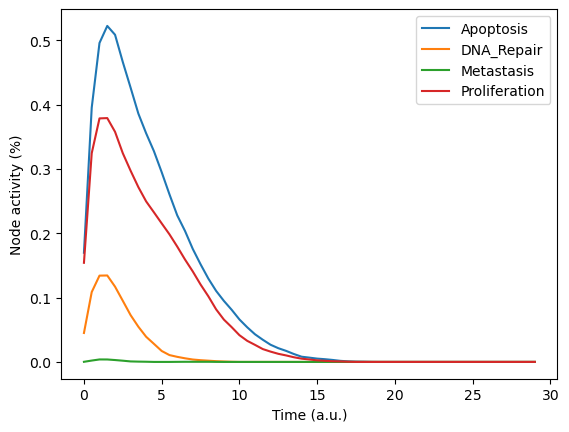

In [21]:
maboss_wtA_result = maboss_wtA_model.run()

maboss_wtA_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig("3A.pdf")

In [22]:
# MC debug.
name = "A"
with open(f"{name}.bnd", mode='w') as f:
    maboss_wtA_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_wtA_model.print_cfg(f)

In [23]:
# MC debug.
# Trajectory of Proliferation is decaying faster than the plot on the article, e.g. there is no intersection with Apoptosis at about time 5. This could be an effect of the stocasticity of the simulation.
# I can check the next plots to see if something odd is going on with the trajectory associated to Metastasis.
# Also something is off with p53 and E2F1.

# I try to print and compare the CFG and BND files of my notebook and the reference notebook. No relevant differences are present(e.g. I use only one thread to run the simulation but also setting 6 does not change anything).
# I even tried to load the maboss model from biolqm instead of using ginsim. The result is the same.
# Also using the model v1 does not change anything.
# Also I tried to run the simulation for 40 a.u. and not 30 a.u. but nothing changed.

# Now 20230619 the reference notebook makes my same plots, I don't know why. I tried every combination of the source files: no change.
# At this point I give up the idea on the idea to exaclty reproduce the plots fromt the article since data to reproduce the exact results are not provided.
# Now I follow what Prof. Calzone told me which essentially is to experiment with data and understand what happens.

The second simulation has input nodes in list `actives_wtB` active from the start. Moreover node "SPOP" is set with random initial state.

Phenotypes of the second simulation are listed in variable `outputs_wtB` and includes some intermediate nodes other than some output nodes.

In [24]:
maboss_wtB_model = maboss_wtA_model.copy()

actives_wtB = ["EGF", "FGF", "Nutrients", "Androgen"]
for node in actives_wtB:
    maboss_wtB_model.network.set_istate(node, [0, 1])
maboss_wtB_model.network.set_istate("SPOP", [0.5, 0.5])

outputs_wtB = ["Apoptosis", "CyclinD", "E2F1", "Metastasis", "Proliferation", "p53"]
maboss_wtB_model.network.set_output(outputs_wtB)

The trajectory plot of the second simulation is:

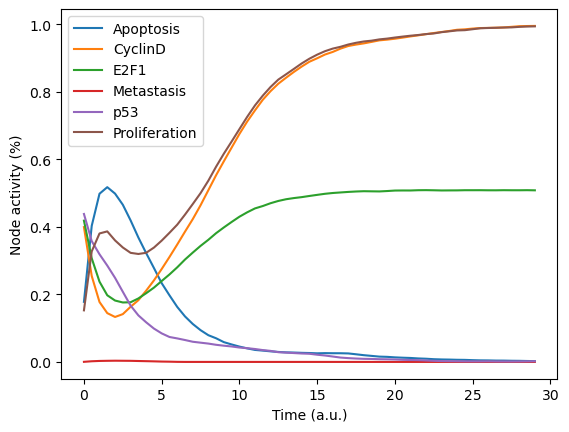

In [25]:
maboss_wtB_result = maboss_wtB_model.run()

maboss_wtB_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig("3B.pdf")

In [26]:
# MC debug.
name = "B"
with open(f"{name}.bnd", mode='w') as f:
    maboss_wtB_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_wtB_model.print_cfg(f)

The third simulation is executed with initial state active for the nodes in list `actives_wtC` and the output nodes are the same of the second simulation.

In [27]:
maboss_wtC_model = maboss_wtA_model.copy()

actives_wtC = ["Carcinogen", "Androgen", "TNFalpha", "Acidosis", "Hypoxia"]
for node in actives_wtC:
    maboss_wtC_model.network.set_istate(node, [0, 1])

maboss_wtC_model.network.set_output(outputs_wtB)

The trajectory plot of the third simulation is:

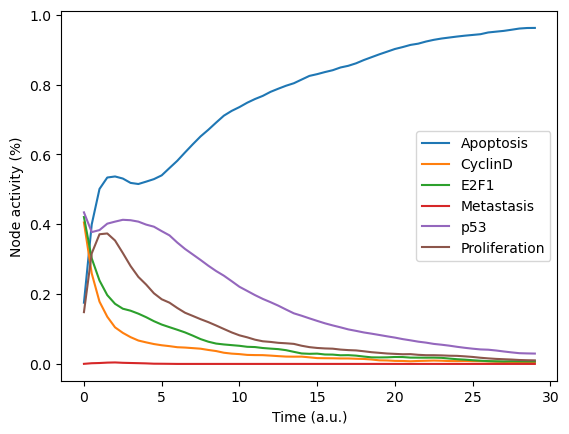

In [28]:
maboss_wtC_result = maboss_wtC_model.run()

maboss_wtC_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig("3C.pdf")

In [29]:
# MC debug.
name = "C"
with open(f"{name}.bnd", mode='w') as f:
    maboss_wtC_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_wtC_model.print_cfg(f)

## Model validation
The model is validated by simulating some known interactions between genes in prostate cells under physiological conditions.

For example the order of events during cell cycle is tested. In this case the initial conditions are active growth factors and nutrients, along with nodes related to the activation of the cell cycle, while the cyclins start inactive. All the other nodes have random initial state. The outputs are list in variable `outputs_cellcycle`.

In [30]:
maboss_cellcycle_model = maboss_wtA_model.copy()

actives_cellcycle = ["EGF", "FGF", "Nutrients", "p21", "RB1"]
for node in actives_cellcycle:
    maboss_cellcycle_model.network.set_istate(node, [0, 1])

inactives_cellcycle = ["CyclinB", "CyclinD", "E2F1"]
for node in inactives_cellcycle:
    maboss_cellcycle_model.network.set_istate(node, [1, 0])

outputs_cellcycle = ["CyclinB", "CyclinD", "E2F1", "Proliferation"]
maboss_cellcycle_model.network.set_output(outputs_cellcycle)

The result of the simulation are the following trajectories:

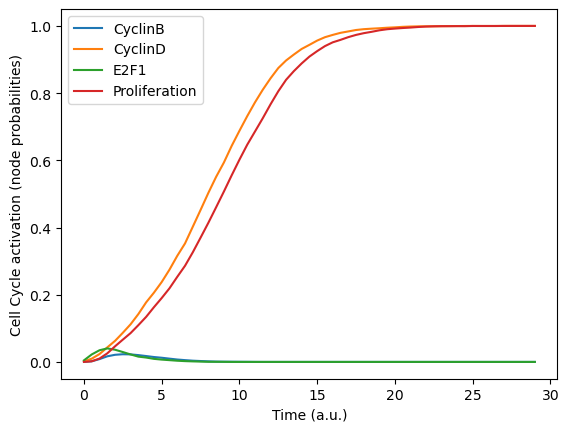

In [32]:
maboss_cellcycle_result = maboss_cellcycle_model.run()

maboss_cellcycle_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Cell Cycle activation (node probabilities)"
)
plt.savefig("5.pdf")

In [34]:
# MC debug.
name = "5"
with open(f"{name}.bnd", mode='w') as f:
    maboss_cellcycle_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_cellcycle_model.print_cfg(f)

## Mutants simulation
The model can be used to study the effect of mutations which activate or disable some nodes, or in general which deviate their functioning from physiological conditions.

### Single mutations
One case is the permanent inactivation of node "FOXA1". Except for the mutation, this simulation has the same initial conditions as the wild type model and all the output nodes are observed as phenotypes.

In [42]:
maboss_FOXA1_model = maboss_wtA_model.copy()

maboss_FOXA1_model.mutate("FOXA1", "OFF")

# MC debug.
maboss_FOXA1_model.network.set_istate("EGF", [0,1])
maboss_FOXA1_model.network.set_istate("FGF", [0,1])
maboss_FOXA1_model.network.set_istate("Nutrients", [0,1])
maboss_FOXA1_model.network.set_istate("SPOP", [0.5,0.5])

outputs_network = df_nodes_pathways.loc[df_nodes_pathways["pathway"] == "Output"]["node"].tolist()
maboss_FOXA1_model.network.set_output(outputs_network)

The results of this simulation are

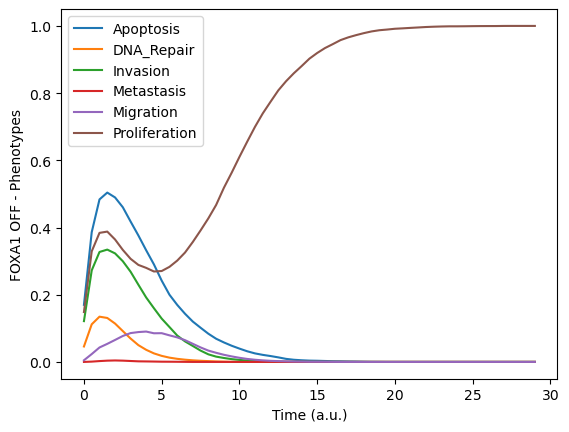

In [43]:
maboss_FOXA1_result = maboss_FOXA1_model.run()

maboss_FOXA1_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="FOXA1 OFF - Phenotypes"
)
plt.savefig("6A.pdf")

In [37]:
# MC debug.
name = "6A"
with open(f"{name}.bnd", mode='w') as f:
    maboss_FOXA1_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_FOXA1_model.print_cfg(f)

Another mutation affecting a single node is the inactivation of gene TP53, which affects the inactivation of node "p53". Phenotype "Caspase3" is added to the outputs of the previous simulation.

In [53]:
maboss_p53_model = maboss_wtA_model.copy()

maboss_p53_model.mutate("p53", "OFF")

outputs_p53 = outputs_network.copy()
outputs_p53.append("Caspase3")
maboss_p53_model.network.set_output(outputs_p53)

The result of the simulation is

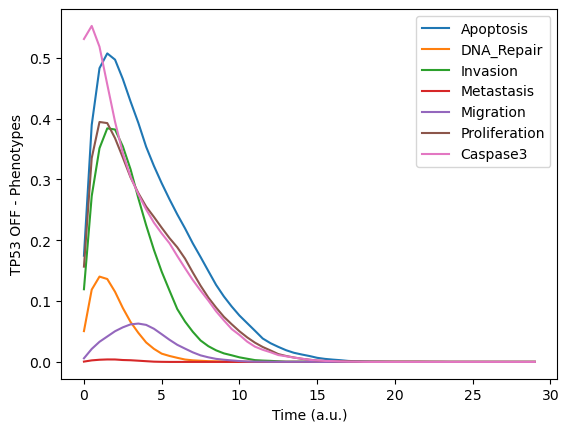

In [54]:
maboss_p53_result = maboss_p53_model.run()

maboss_p53_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="TP53 OFF - Phenotypes"
)
plt.savefig("6B.pdf")

### Multiple mutations
During cancer progression multiple mutations accumulate and their effects and interactions can be simulated.

An example is the interaction between gene fusion TMPRSS2:ERG and a loss-of-function mutation of gene NKX3_1. The starting model is the wild type model, with active nodes in list `actives_multiple` and random value for node "SPOP" as initial conditions. Outputs of the simulation are the output nodes of the network. Then mutations are applied simultaneously.

In [56]:
maboss_multiple_model = maboss_wtA_model.copy()

actives_multiple = ["EGF", "FGF", "Nutrients", "Carcinogen"]
for node in actives_multiple:
    maboss_multiple_model.network.set_istate(node, [0, 1])
maboss_multiple_model.network.set_istate("SPOP", [0.5, 0.5])

outputs_network.append("AR_ERG")  # MC debug.
maboss_multiple_model.network.set_output(outputs_network)

maboss_multiple_model.mutate("AR_ERG", "ON")
#maboss_multiple_model.network.set_istate("AR_ERG", [0, 1])  # MC debug.
maboss_multiple_model.mutate("NKX3_1", "OFF")

The result of the simulation is

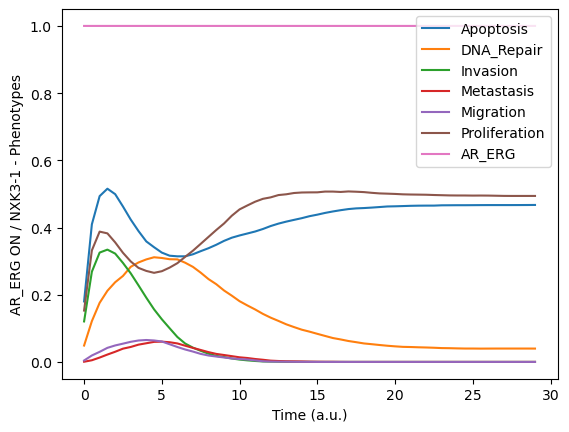

In [57]:
maboss_multiple_result = maboss_multiple_model.run()

maboss_multiple_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="AR_ERG ON / NXK3-1 - Phenotypes"
)
plt.savefig("7.pdf")

In [51]:
# MC debug.
name = "7"
with open(f"{name}.bnd", mode='w') as f:
    maboss_multiple_model.print_bnd(f)
with open(f"{name}.cfg", mode='w') as f:
    maboss_multiple_model.print_cfg(f)

In [60]:
# MC debug.
display(df_nodes_interactions.info())
display(df_nodes_interactions.loc[
    (df_nodes_interactions["Target node"] == "Metastasis") |
    (df_nodes_interactions["Target node"] == "Migration") |
    (df_nodes_interactions["Target node"] == "Invasion")
])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Target node       462 non-null    object
 1   HUGO names        454 non-null    object
 2   Interaction type  462 non-null    object
 3   Source            462 non-null    object
 4   Description       462 non-null    object
 5   Reference: PMID   453 non-null    object
 6   Logical rule      462 non-null    object
dtypes: object(7)
memory usage: 25.4+ KB


None

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
244,Invasion,output,+,beta_catenin,Deletion of β-Catenin in a Pten deleted model ...,23300485,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_c...
245,Invasion,output,+,CDH2,N-cadherin is required for TGFbeta induced inv...,15331629,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_c...
246,Invasion,output,+,EZH2,EZH2 regulates tumor invasion via the transcri...,22505648,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_c...
247,Invasion,output,+,SMAD,"TGF-b induces MMP-2 and MMP-9 expresion, using...",22614218,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_c...
276,Metastasis,output,+,AR_ERG,The overexpression of ERG is one of the key fa...,25915839,(Migration & AR_ERG)
277,Metastasis,output,+,ERG,The overexpression of ERG is one of the key fa...,25915839,(Migration & AR_ERG)
278,Metastasis,output,+,Migration,"From Cohen et al, 2015",26528548,(Migration & AR_ERG)
279,Migration,output,+,AKT,"Overall, we have dissected signaling pathways ...",26207671,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
280,Migration,output,+,AR,"The present report, for the first time, indica...",21359179,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
281,Migration,output,+,EMT,"From Cohen et al, 2015",26528548,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)


# Personalisation of the prostate Boolean model
The wild type model can be integrated with data derived from experiments and existing databases, to create personalised models for patient-specific analysis and treatments. Authors follow their PROFILE methodology using bulk omics data.

## Phenotype distribution of TCGA patients